In [27]:
import sys
sys.path.append("..")

import torch
import torchtext

import matplotlib.pyplot as plt
device = torch.cuda.device(0)

In [13]:
import cfg

from text_classification import trainutils
from text_classification.layers import CharCNN
from text_classification.datautils import CharIMDB
from train import train

In [14]:
text_field = torchtext.data.Field(
    lower=True, include_lengths=False, tensor_type=torch.FloatTensor, batch_first=True,
    tokenize=lambda x: x, use_vocab=False, sequential=False
)
label_field = torchtext.data.Field(sequential=False, use_vocab=False)

CharIMDB.maxlen = 512
train_data, test_data = CharIMDB.splits(text_field, label_field, root='../.data')

train_dataloader, val_dataloader, test_dataloader = \
    trainutils.get_dataloaders(train_data, test_data, batch_size=cfg.train.batch_size,
                               valid_size=cfg.train.val_size)


In [29]:
class LRFinder:
    def __init__(self, optimizer, max_lr=1e1, min_lr=1e-5, iters=1000):
        self.max_lr = max_lr
        self.min_lr = min_lr
        self.iters = iters
        self._optimizer = optimizer
        self._mult = (max_lr / min_lr) ** (1 / iters)
        self._lr = min_lr

    def __next__(self):
        self._lr *= self._mult
        return self._lr

    def batch_step(self):
        """
        Updates lr of optimizer
        """
        lr = self.__next__()
        for param in self._optimizer.param_groups:
            param['lr'] = lr

    def find_for(self, model):
        lr_hist = []
        loss_hist = []
        
        for _ in self.iters:
            lr = self.__next__()
            

In [30]:
lrfinder = LRFinder(None)

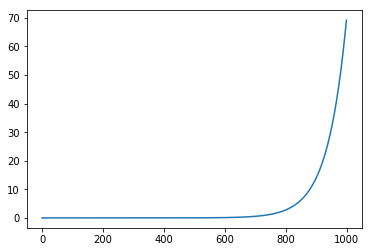

In [32]:
lr_hist = []

for _ in range(1000):
    lr_hist.append(next(lrfinder))

plt.plot(lr_hist)

In [25]:
next(lrfinder)

9.840111057611336

In [34]:
from tqdm import tqdm

In [48]:
def find_lr(model, dataloader, optimizer_class, loss_f, max_lr=1e1, min_lr=1e-5, epochs=1):

    optimizer = optimizer_class(model.parameters(), lr=min_lr)
    mult = (max_lr / min_lr) ** (1 / (len(dataloader) * epochs))
    lr = min_lr

    lr_hist = []
    loss_hist = []

    for epoch in range(epochs):
        for i, (x, y) in tqdm(enumerate(dataloader), total=len(dataloader)):
            optimizer.zero_grad()

            lr *= mult
            for param in optimizer.param_groups:
                param['lr'] = lr

            x = x.cuda()
            y = torch.LongTensor(y).cuda()

            x = x.permute(1, 0, 2)
            pred = model(x)
            loss = loss_f(pred, y)

            lr_hist.append(lr)
            loss_hist.append(loss.data)

    plt.plot(lr_hist, loss_hist)
    return lr_hist, loss_hist

100%|██████████| 665/665 [00:04<00:00, 152.04it/s]


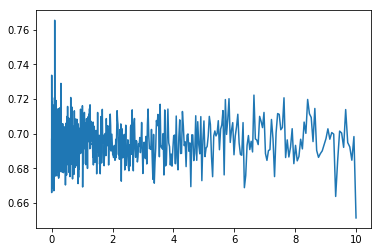

In [50]:
model = CharCNN(256, 5, 512, len(cfg.alphabet))
model.cuda()
lr_hist, loss_hist = find_lr(model, train_dataloader, torch.optim.Adam, torch.nn.functional.cross_entropy, epochs=3)